# 1. Imports

In [145]:
import warnings
import inflection

import pandas     as pd
import seaborn    as sns
import numpy      as np
import scikitplot as skplt

from IPython.core.display    import HTML
from IPython.display         import Image

from boruta                  import BorutaPy
from matplotlib              import pyplot   as plt

from imblearn.over_sampling  import SMOTE, SMOTENC
from imblearn.combine        import SMOTETomek
from imblearn.under_sampling import TomekLinks

from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics         import roc_auc_score, roc_curve, plot_confusion_matrix

## 1.1. Helper Functions

### 1.1.1. General

In [146]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 11

    display( HTML( '<style>.container { width:80% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option( 'display.max_columns', None )

    sns.set_style("whitegrid")
    sns.set_palette("muted")

    warnings.filterwarnings('ignore')

### 1.1.2. Metrics

In [147]:
def ml_metrics(model_name, y, y_pred):
    
    acc     = accuracy_score( y, y_pred ) 
    prec    = precision_score( y, y_pred )
    rec     = recall_score( y, y_pred )
    f1score = f1_score( y, y_pred ) 
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'Accuracy'  : acc,
                           'Recall'    : rec,
                           'F1 Score'  : f1score }, index=[0] )


def get_lift_gain(model, X, y, step=0.1):
    
    lift_list = []
    gain_list = [0]
    
    y_pred_proba = model.predict_proba(X)[:,1]
    df_y = pd.DataFrame({"y":y.values, "y_proba":y_pred_proba}).sort_values( by='y_proba', ascending=False )
    
    sample_axis = np.arange( step, step+1, step )
    total_numb_of_samples = df_y.shape[0]
    total_numb_of_positives = df_y['y'].sum()
    total_positive_ratio = total_numb_of_positives / total_numb_of_samples
    
    for sample_pct in sample_axis:
        numb_of_samples = int(np.ceil(sample_pct*total_numb_of_samples))
        df_aux = df_y.iloc[ :numb_of_samples, : ]
        
        numb_of_positives = df_aux['y'].sum()
        positive_ratio = numb_of_positives / numb_of_samples
        
        lift_list.append( positive_ratio / total_positive_ratio )
        gain_list.append( numb_of_positives / total_numb_of_positives )
    
    return lift_list, gain_list 

### 1.1.2. For Plot

In [257]:
def plot_histogram(df, cols, normalized=False):
    mask = df['exited'] == 1
    
    if len(cols) <= 3:
        n_rows = 1
        n_cols = len(cols)
    else:
        n_rows = int(np.ceil(len(cols)/3))
        n_cols = 3
    
    fig, axes = plt.subplots(n_rows, n_cols)
    for ax_i, col in zip(axes.ravel(), cols):
        ax_i.hist( df5[mask][col] , histtype='step', density=normalized, label='Churn'     , linewidth=2 )
        ax_i.hist( df5[~mask][col], histtype='step', density=normalized, label='Not Churn' , linewidth=2 )
        ax_i.set_xlabel(col)
        ax_i.legend()
    
    return None
    
    
def get_colors():
    return ['blue', 'black', 'green', 'purple', 'yellow', 'red']


def plot_cumulative_gain(ax, gains, models, churn_ratio=0.2, step=0.1):
    ax.plot([0, churn_ratio, 1], [0, 1, 1], 'r--', linewidth=2, label='Ideal Classifier')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    
    colors = get_colors()
    
    for gain, model, color in zip(gains, models, colors):    
        ax.plot(np.arange(0, 1. + step, step), gain, linewidth=2, color=color, label=model)

    ax.set_title(f'Cumulative Gains')
    ax.set_xlabel(f'Percentage of Sample')
    ax.set_ylabel('Percentage of Churned Customers')
    ax.legend(loc='lower right')

    ticks = np.arange(0., 1.2, .2)
    ax.set_xticks(ticks=ticks, minor=False)
    ax.set_xticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.set_xlim(0, 1.)
    ax.set_yticks(ticks=ticks, minor=False)
    ax.set_yticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.set_ylim(0, 1.02)
    
    ax.grid(True, which='major', axis='y', color='gray', linestyle='-', alpha=.5)
    ax.grid(True, which='major', axis='x', color='gray', linestyle='-', alpha=.5)
    
    return None


def plot_lift_curve(ax, lifts, models, step):
    x = np.arange(step, step + 1, step)
    
    colors = get_colors()
    
    ax.plot(x, np.ones(len(x)), 'k--', label='Baseline')
    for lift, model, color in zip(lifts, models, colors):
        ax.plot(x, lift, '-', color=color, linewidth=3, markersize=5, label=model)
    ax.set_xlabel('Percentage of Sample')
    ax.set_ylabel('Lift')
    ax.set_title('Lift Curve')
    
    ticks = np.arange(0, 1.1, .1)
    ax.set_xticks(ticks, minor=False)
    ax.set_xticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.legend(loc='best')
        
    ticks = np.arange(0.1, 1.1, .1)
    ax.set_xticks(ticks=ticks, minor=False)
    ax.set_xticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.set_xlim(0.1, 1.)
    
    lift_max = np.ceil(max(max(lifts)))
    ticks = np.arange(0, lift_max + 1, 1)
    ax.set_yticks(ticks=ticks, minor=False)
    ticks = np.arange(0.5, lift_max, .5)
    ax.set_yticks(ticks=ticks, minor=True)
    ax.set_ylim(0, lift_max + .5)
    
    ax.grid(True, which='major', axis='x', color='gray', linestyle='-', alpha=.5)
    ax.grid(True, which='major', axis='y', color='gray', linestyle='-', alpha=.5)
    ax.grid(True, which='minor', axis='y', color='gray', linestyle='-', alpha=.1)
    
    return ax

def plot_lift_gain_curves(gains, lifts, models, churn_ratio=0.2, step=0.1):
    fig, axes = plt.subplots(1,2)
    plot_cumulative_gain(axes[0], gains, models, step=0.1)
    plot_lift_curve(axes[1], lifts, models, step=0.1)
    
    return None

## 1.2. Loading Data

In [149]:
jupyter_settings()

In [150]:
df1 = pd.read_csv( '../data/churn.csv' ).drop( columns='RowNumber' )
df1.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 2. Data Description

In [166]:
df2 = df1.copy()

## 2.1. Renaming Columns

In [167]:
cols_old = df2.columns
snake_case = lambda x: inflection.underscore(x)
cols_new = list( map(snake_case, cols_old) )

# rename columns
df2.columns = cols_new
df2.columns

Index(['customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age',
       'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 2.1. Data Dimensions

In [168]:
print( 'Number of rows: {}'.format( df2.shape[0] ) )
print( 'Number of columns: {}'.format( df2.shape[1] ) )

Number of rows: 10000
Number of columns: 13


## 2.2. Data Types

In [169]:
df2.dtypes

customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 2.3. Check NA

In [170]:
df2.isna().sum()

customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 2.4. Fillout NA

## 2.5. Change Data Types

## 2.6. Descriptive Statistics

In [171]:
num_attrib = df2.select_dtypes( include=[int, float] )
cat_attrib = df2.select_dtypes( include=object )

### 2.6.1. Numerical Attributes

In [173]:
num_attrib.describe()

,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### 2.6.1. Categorical Attributes

In [174]:
# number of unique values
cat_attrib.apply( lambda x: x.unique().shape[0] )

surname      2932
geography       3
gender          2
dtype: int64

# 3. Feature Engineering

In [175]:
df3 = df2.copy()

## 3.1. Mind Map

## 3.2. Creating Hypotheses

**1.** The older (Age) the customers, the more likely they are to churn.

**2.** The number of churned customers without a credit card is greater than the ones with credit card. 

**3.** The lower the credit score of the customers, the more likely they are to churn.

**5.** Customers with an estimated salary less than 50000 are more likely to churn.

**6.** Customers who spent less than the average are more likely to churn.

**7.** Customers who were active for less time are more likely to churn.

**8.** Customers who are not active members are more likely to churn.

## 3.3. Creating New Features

# 4. Data Filtering

In [176]:
df4 = df3.copy()

# 5. EDA

In [202]:
df5 = df4.copy()

## 5.1. Univariate Analysis

### 5.1.1. Numerical Attributes

In [223]:
num_attrib.columns

Index(['customer_id', 'credit_score', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

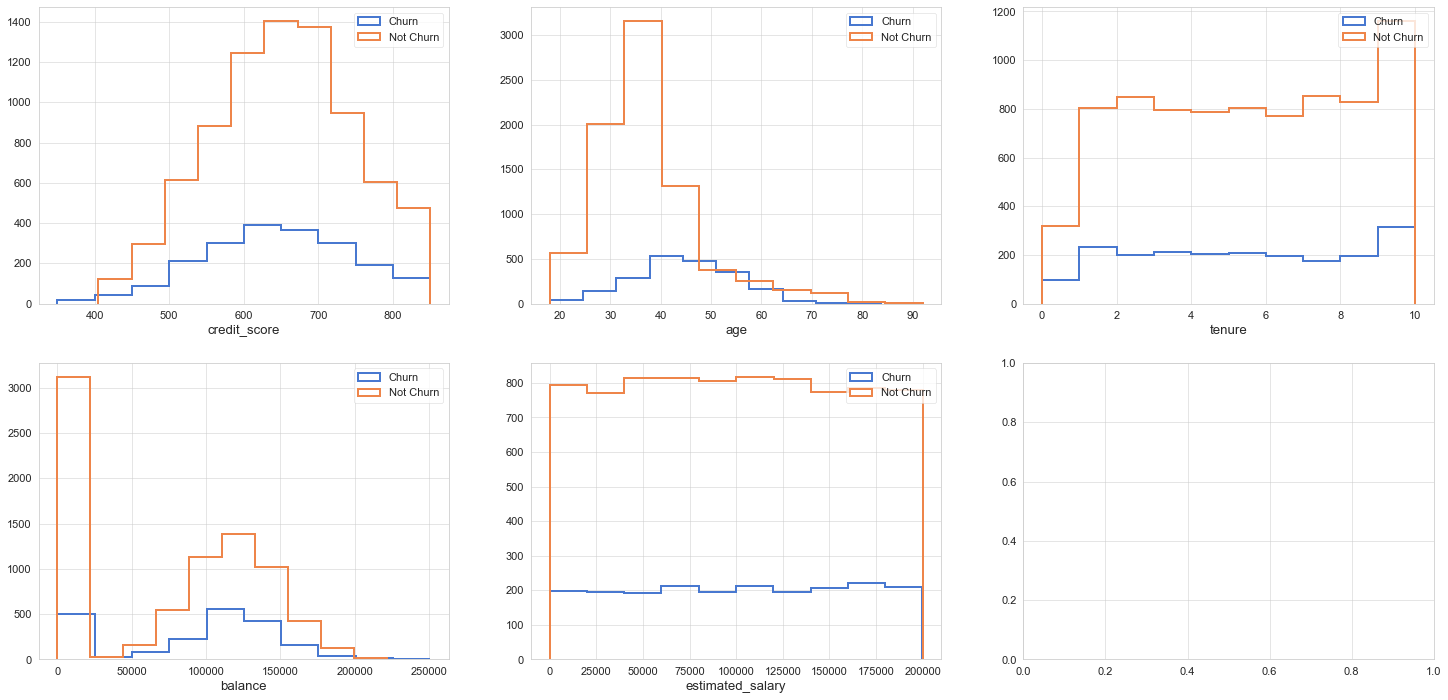

In [260]:
cols = ['credit_score', 'age', 'tenure', 'balance','estimated_salary']
plot_histogram(df5, cols)

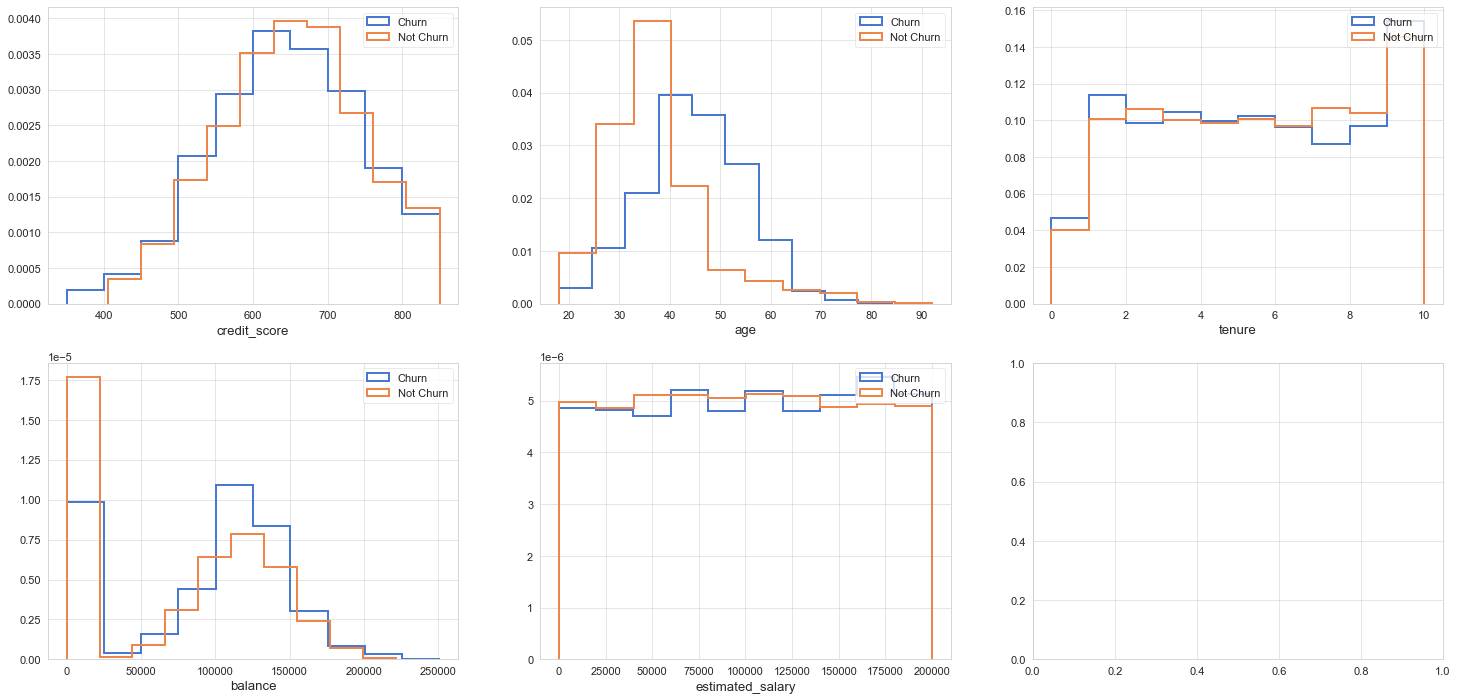

In [261]:
plot_histogram(df5, cols, normalized=True)

### 5.1.1. Categorical Attributes

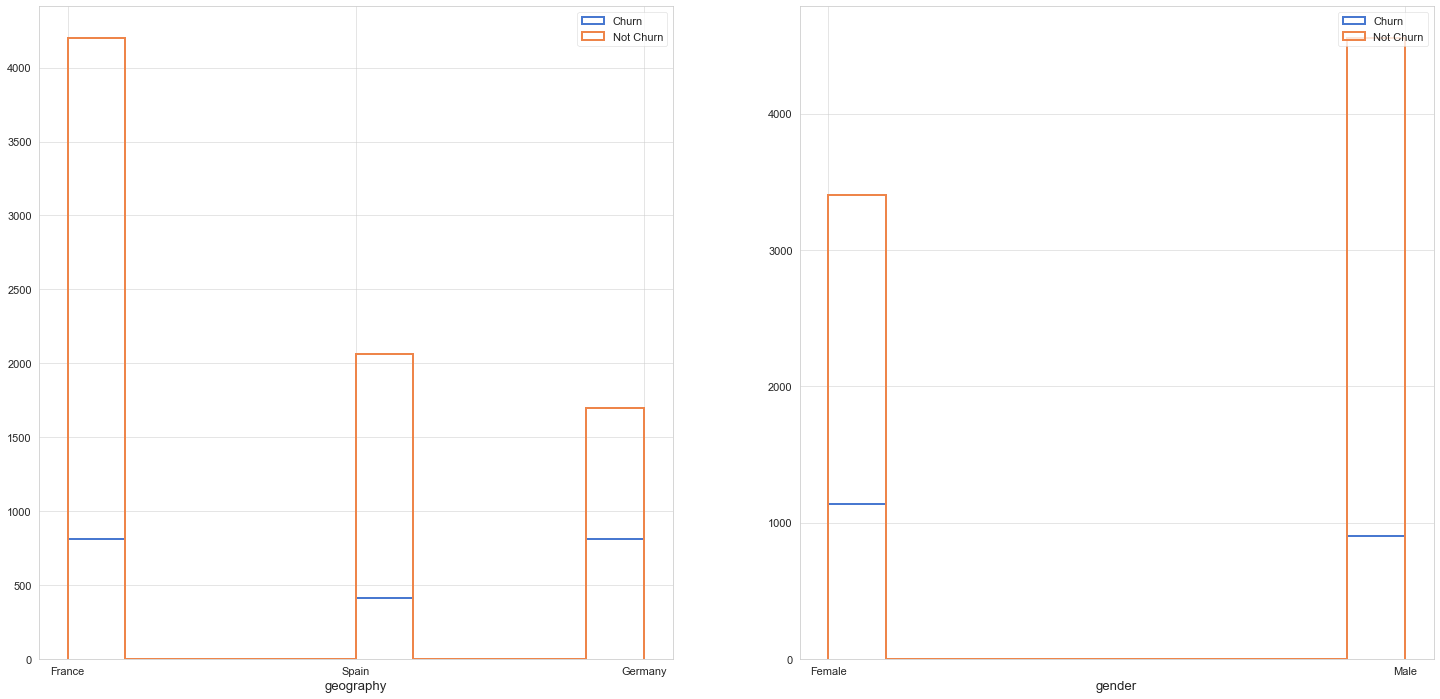

In [263]:
cols = ['geography', 'gender']
plot_histogram(df5, cols)

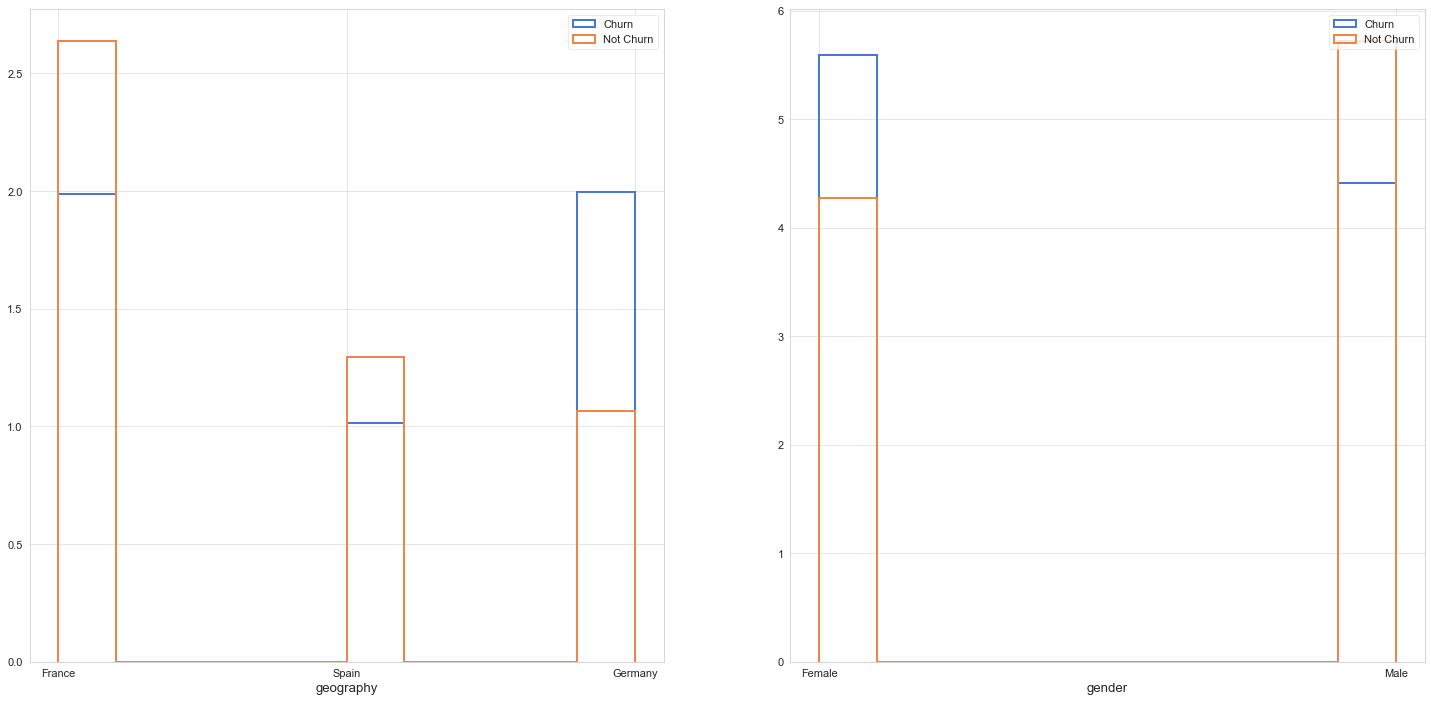

In [264]:
plot_histogram(df5, cols, True)

## 5.2. Bivariate Analysis 

### H1. The older (Age) the customers, the more likely they are to churn.
* **PARTIALLY TRUE** - Up to 50-56 years the statement is true, however after that the behavior inverts.

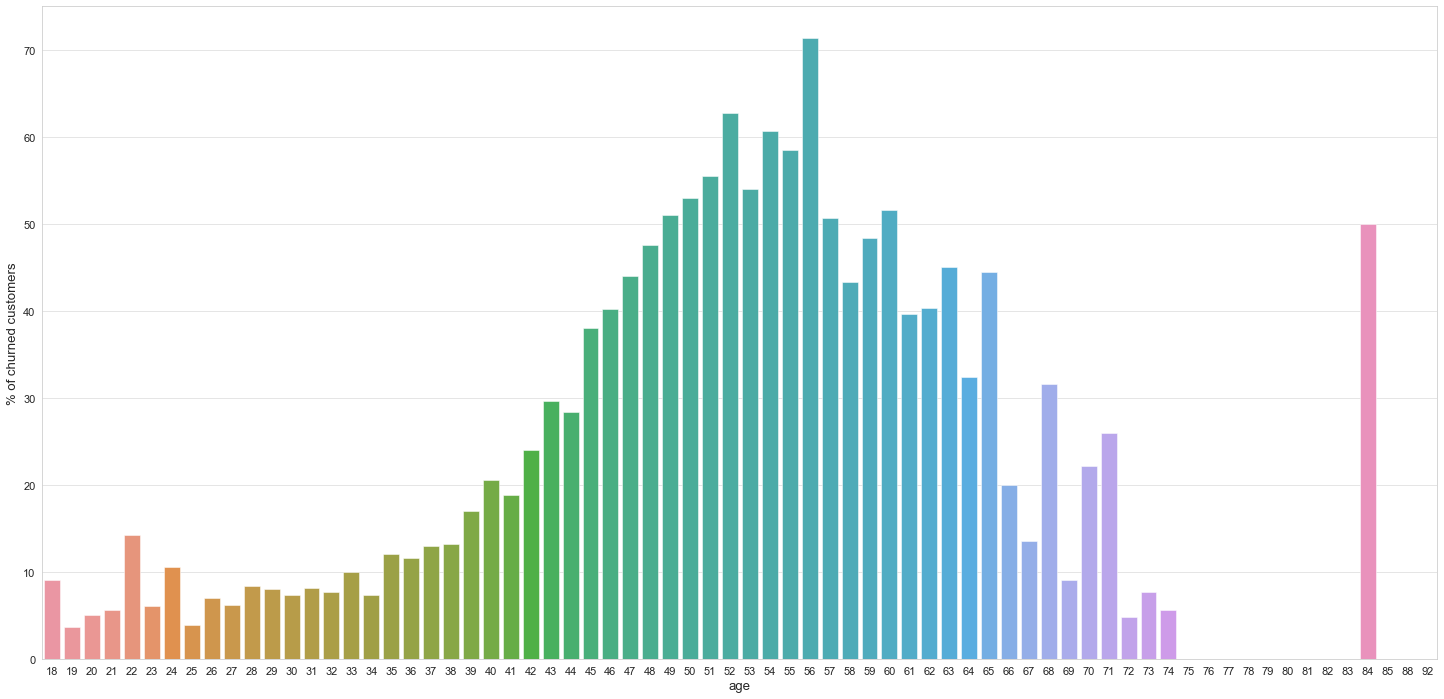

In [212]:
df_aux = df5[['age', 'exited']].groupby( 'age' )['exited'].apply( lambda x: x.mean() * 100 ).reset_index()
df_aux.rename( columns={'exited':'% of churned customers'}, inplace=True )

sns.barplot( x='age', y='% of churned customers', data=df_aux );

### H2. The number of churned customers without a credit card is greater than the ones with credit card. 
* **FALSE** - The number of churned customers without a credit card is **LOWER** than the ones with credit card. 

In [213]:
df_aux = df5[['has_cr_card', 'exited']].groupby( 'has_cr_card' ).agg({"exited":["mean", "sum"]})
df_aux.columns = ["Churn Rate", "Nº of customers"]
df_aux

,Churn Rate,Nº of customers
has_cr_card,,
0,0.208149,613
1,0.201843,1424


### H3. The lower the credit score of the customers, the more likely they are to churn.
* **PARTIALLY TRUE** - Up to 450 credit score the statment is true. Especially the customers with a credit score below 400, where the churn rate is 100%.

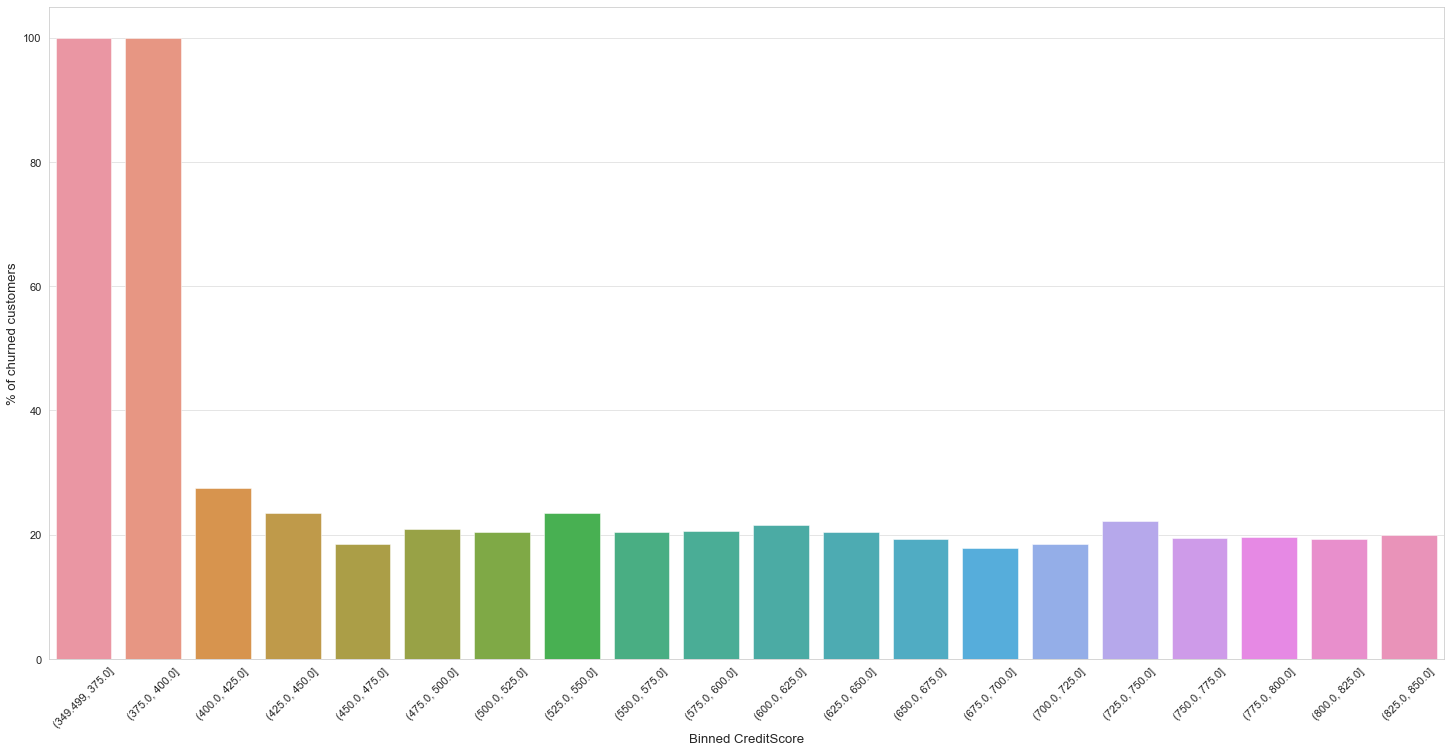

In [214]:
df_aux = df5.copy()
df_aux['Binned CreditScore'] = pd.cut(df_aux['credit_score'], bins=20, include_lowest=True)

df_aux = df_aux[['Binned CreditScore', 'exited']].groupby( 'Binned CreditScore' ).apply( lambda x: x.mean() * 100 ).reset_index()
df_aux.rename( columns={'exited':'% of churned customers'}, inplace=True )

sns.barplot( x='Binned CreditScore', y='% of churned customers', data=df_aux)
plt.xticks(rotation=45);

### H4. Customers who bought just one product are more likely to churn.
* **FALSE** - Customers who bought **four** products are more likely to churn.

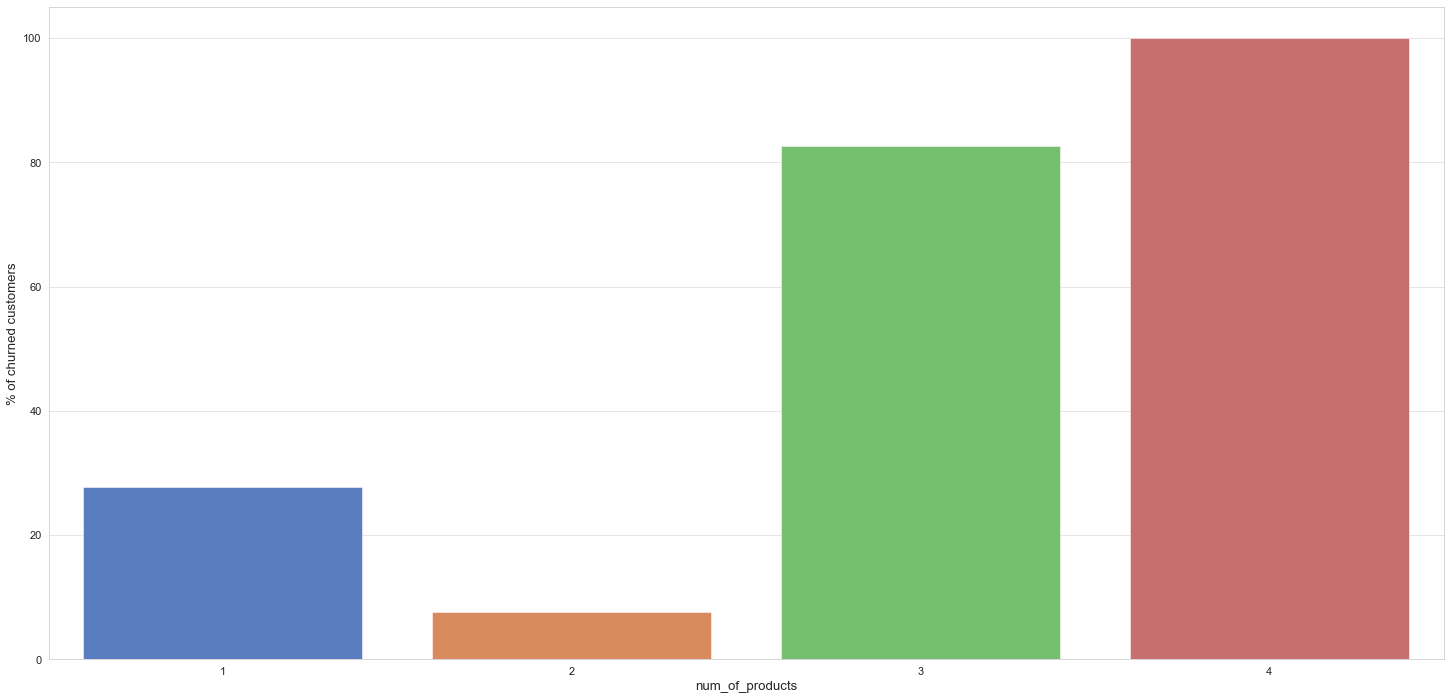

In [216]:
df_aux = df5[['num_of_products', 'exited']].groupby( 'num_of_products' )['exited'].apply( lambda x: x.mean() * 100 ).reset_index()
df_aux.rename( columns={'exited':'% of churned customers'}, inplace=True )

sns.barplot( x='num_of_products', y='% of churned customers', data=df_aux);

### H5. Customers with an estimated salary less than 50000 are more likely to churn.
* **FALSE** - There is no direct correlation between salary and churn rate.

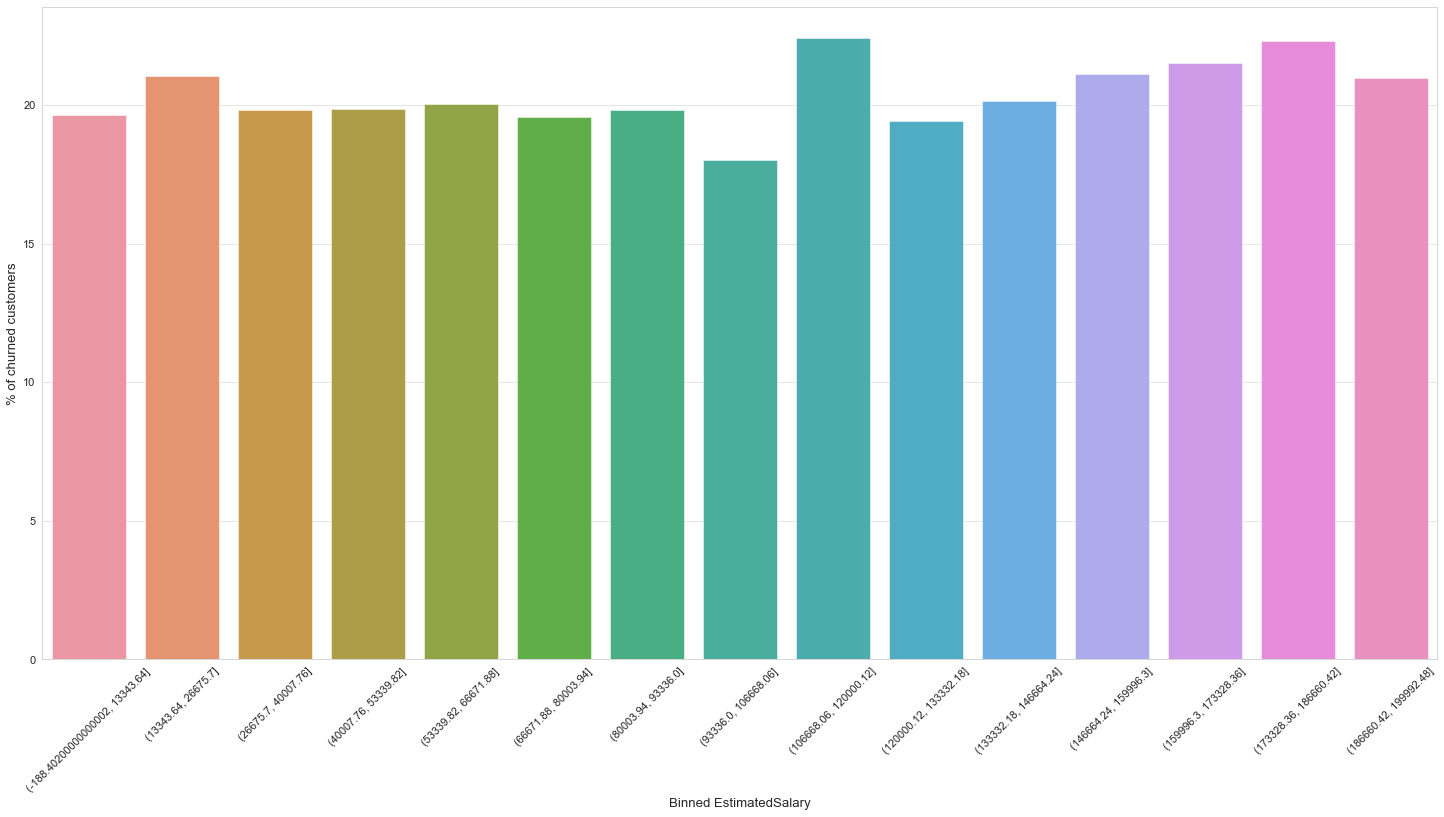

In [217]:
df_aux = df5.copy()
df_aux['Binned EstimatedSalary'] = pd.cut(df_aux['estimated_salary'], bins=15, include_lowest=True)

df_aux = df_aux[['Binned EstimatedSalary', 'exited']].groupby( 'Binned EstimatedSalary' ).apply( lambda x: x.mean() * 100 ).reset_index()
df_aux.rename( columns={'exited':'% of churned customers'}, inplace=True )

sns.barplot( x='Binned EstimatedSalary', y='% of churned customers', data=df_aux)
plt.xticks(rotation=45);

### H6. Customers who spent less than the average are more likely to churn.
* **FALSE** - Customers who spent **more** than the average are more likely to churn.

In [218]:
df_aux = df5.copy()

balanceMean = df5['balance'].mean()
df_aux['Balance Range'] = df_aux['balance'].apply( lambda x: '<= mean' if x <= balanceMean else '> mean' )

df_aux = df_aux[['Balance Range', 'exited']].groupby( 'Balance Range' ).agg({"exited":["mean", "sum"]})
df_aux.columns = ["Churn Rate", "Nº of customers"]

df_aux

,Churn Rate,Nº of customers
Balance Range,,
<= mean,0.149718,611
> mean,0.240919,1426


### H7. Customers who were active for less time are more likely to churn.
* **FALSE** - There is no direct correlation between active time and churn rate.

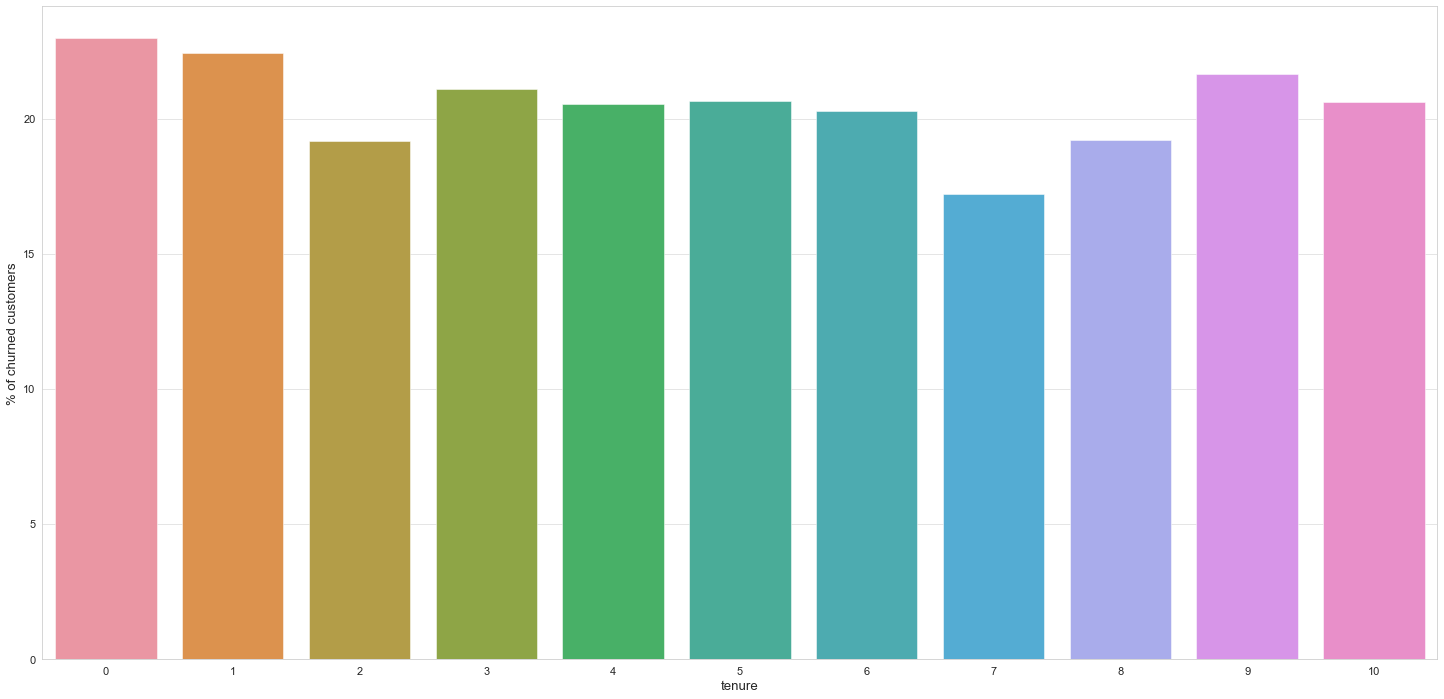

In [219]:
df_aux = df5[['tenure', 'exited']].groupby( 'tenure' )['exited'].apply( lambda x: x.mean() * 100 ).reset_index()
df_aux.rename( columns={'exited':'% of churned customers'}, inplace=True )

sns.barplot( x='tenure', y='% of churned customers', data=df_aux);

### H8. Customers who are not active members are more likely to churn.
* **TRUE** - There is a difference greater than 10% between the churn rate from active and non-active members.

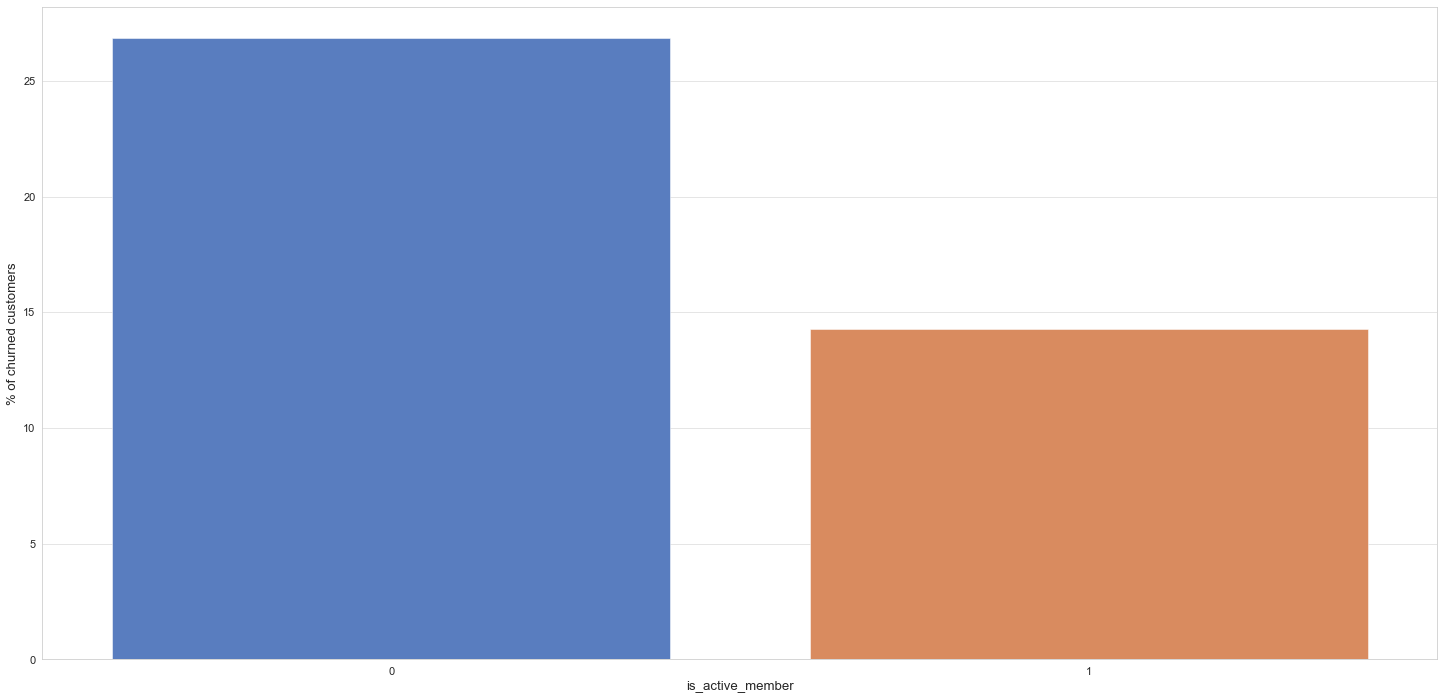

In [220]:
df_aux = df5[['is_active_member', 'exited']].groupby( 'is_active_member' )['exited'].apply( lambda x: x.mean() * 100 ).reset_index()
df_aux.rename( columns={'exited':'% of churned customers'}, inplace=True )

sns.barplot( x='is_active_member', y='% of churned customers', data=df_aux);

# 6. Data Preparation

In [221]:
df6 = df5.copy()

## 6.1. Split Dataset

In [27]:
X = df6.drop( columns=['CustomerId', 'Surname', 'Exited'] )
y = df6['Exited']

X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=42, test_size=0.2  )

## 6.2. Rescaling

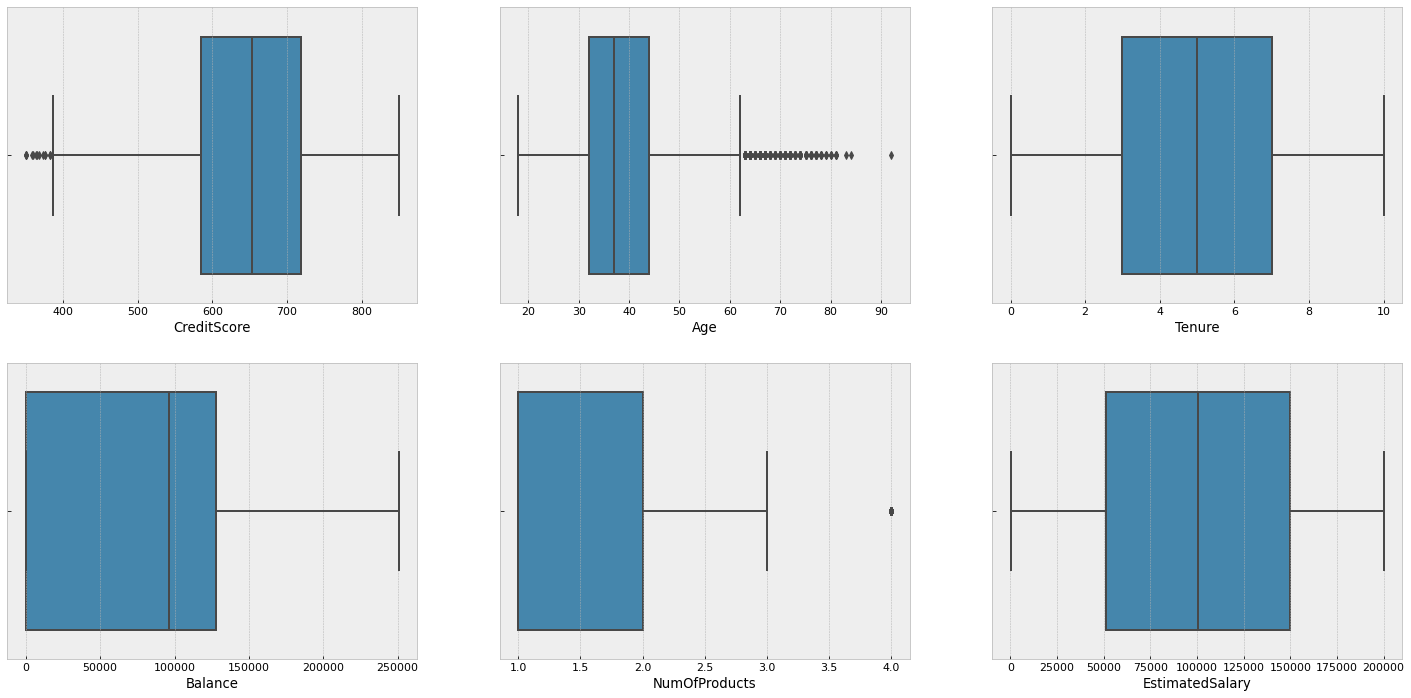

In [28]:
fig, axes = plt.subplots(2,3)

# boxplots for the numerical features
sns.boxplot( x='CreditScore', data=X_train, ax=axes[0,0] )
sns.boxplot( x='Age', data=X_train, ax=axes[0,1] )
sns.boxplot( x='Tenure', data=X_train, ax=axes[0,2] )
sns.boxplot( x='Balance', data=X_train, ax=axes[1,0] )
sns.boxplot( x='NumOfProducts', data=X_train, ax=axes[1,1] )
sns.boxplot( x='EstimatedSalary', data=X_train, ax=axes[1,2] );

In [29]:
# MinMaxScaler
ms_tenure = MinMaxScaler()
ms_balance = MinMaxScaler()
ms_estSalary = MinMaxScaler()

X_train['Tenure'] = ms_tenure.fit_transform( X_train[['Tenure']].values )
X_train['Balance'] = ms_balance.fit_transform( X_train[['Balance']].values )
X_train['EstimatedSalary'] = ms_estSalary.fit_transform( X_train[['EstimatedSalary']].values )


# RobustScaler
rs_age = RobustScaler()
rs_creditScore = RobustScaler()
rs_NumOfProducts = RobustScaler()

X_train['Age'] = rs_age.fit_transform( X_train[['Age']].values )
X_train['CreditScore'] = rs_creditScore.fit_transform( X_train[['CreditScore']].values )
X_train['NumOfProducts'] = rs_NumOfProducts.fit_transform( X_train[['NumOfProducts']].values )

In [30]:
# transform test data
X_test['Tenure'] = ms_tenure.transform( X_test[['Tenure']].values )
X_test['Balance'] = ms_balance.transform( X_test[['Balance']].values )
X_test['EstimatedSalary'] = ms_estSalary.transform( X_test[['EstimatedSalary']].values )
X_test['Age'] = rs_age.transform( X_test[['Age']].values )
X_test['CreditScore'] = rs_creditScore.transform( X_test[['CreditScore']].values )
X_test['NumOfProducts'] = rs_NumOfProducts.transform( X_test[['NumOfProducts']].values )

## 6.3. Transformation

### 6.3.1. Encoding

In [31]:
# One Hot Encoding
X_train = pd.get_dummies(X_train, prefix=['Geography'], columns=['Geography'] )

# Label Encoding
Gender_dict = {'Male': 0, 'Female': 1}
X_train['Gender'] = X_train['Gender'].map(Gender_dict)
X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
9254,0.246269,0,-0.416667,0.6,0.000000,1.0,1,1,0.895550,1,0,0
1561,-0.156716,0,0.416667,0.4,0.476786,1.0,1,1,0.980029,0,1,0
1670,-0.701493,0,-1.083333,0.3,0.457317,0.0,1,0,0.429261,0,0,1
6087,-0.686567,1,-0.833333,0.9,0.540606,0.0,1,0,0.765408,1,0,0
6669,-1.014925,0,1.583333,0.9,0.566554,0.0,0,0,0.197107,1,0,0


In [32]:
# transform test data
X_test = pd.get_dummies(X_test, prefix=['Geography'], columns=['Geography'] )
X_test['Gender'] = X_test['Gender'].map(Gender_dict)

## 6.4. Data Sampling

In [33]:
sample_method = SMOTETomek( smote=SMOTENC(categorical_features=[1, 5, 6, 7, 9, 10, 11]), tomek=TomekLinks(sampling_strategy='majority'))

X_train, y_train = sample_method.fit_sample(X_train, y_train)

In [34]:
np.bincount(y_train)

array([6012, 6356], dtype=int64)

# 7. Feature Selection

In [35]:
df7 = df6.copy()

## 7.1. Boruta

In [36]:
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs = -1 )

# define Boruta (Activate to run Boruta)
boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 0, random_state = 42 ).fit( X_train_n, y_train_n )

In [37]:
##(Activate after run Boruta)
cols_selected = boruta.support_.tolist()

## best features
X_train_fs = X_train.copy() 
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'IsActiveMember',
 'EstimatedSalary']

## 7.2. Manual Feature Selection

In [129]:
final_cols_selected = X_train.columns

# 8. Machine Learning Model

In [130]:
x_train = X_train[ final_cols_selected ]
x_test = X_test[ final_cols_selected ]

## 8.1. Logistic Regression

In [131]:
# model
lr_model = LogisticRegression().fit( x_train, y_train )

# prediction
y_pred_lr = lr_model.predict( x_test )

# performance
lr_result = ml_metrics( 'Logistic Regression', y_test, y_pred_lr )
lr_result

,Model Name,Accuracy,Recall,F1 Score
0,Logistic Regression,0.742,0.636132,0.492126


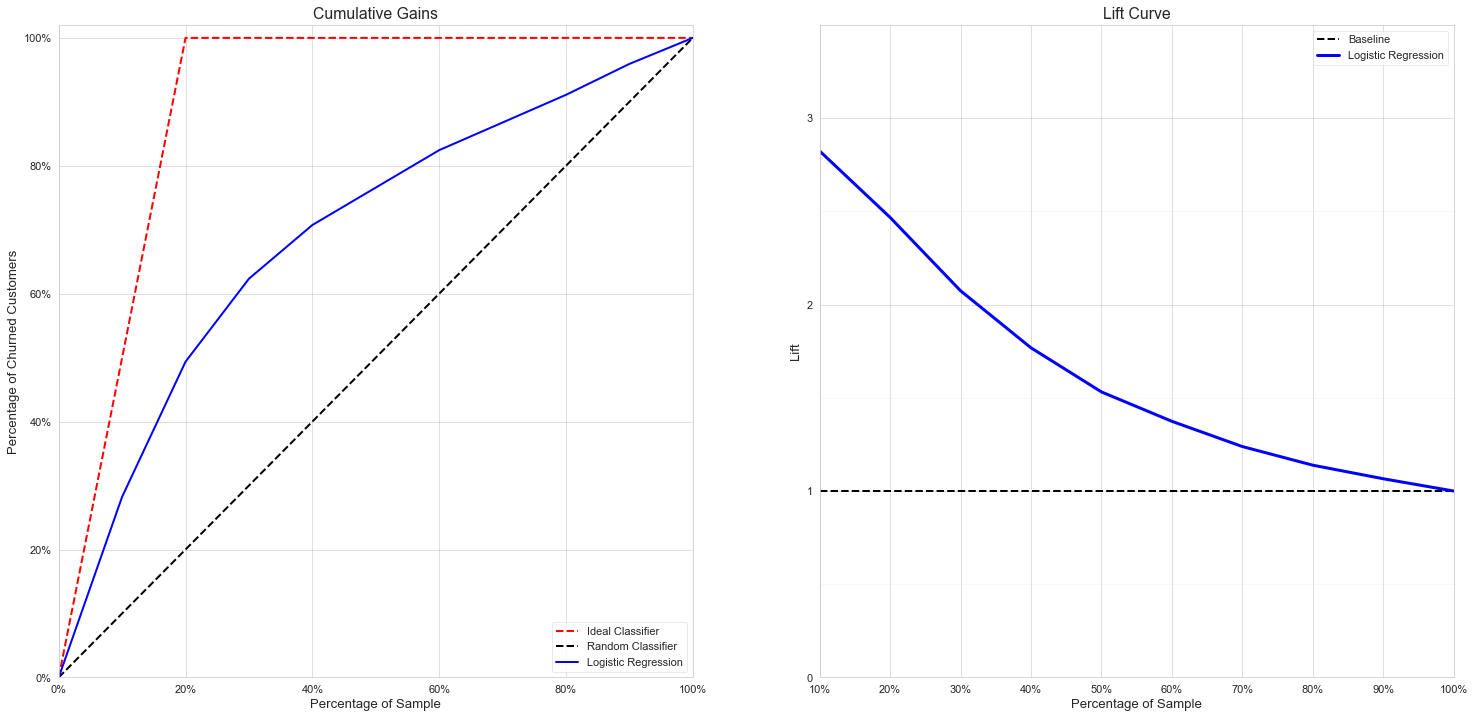

In [132]:
# plot cumulative gain curve and lift curve
lifts, gains = get_lift_gain(lr_model, x_test, y_test)  
plot_lift_gain_curves([gains], [lifts], ['Logistic Regression'], churn_ratio=0.2, step=0.1)

## 8.2. Random Forest Classifier

In [133]:
# model
rf_model = RandomForestClassifier().fit( x_train, y_train )

# prediction
y_pred_rf = rf_model.predict( x_test )

# performance
rf_result = ml_metrics( 'Random Forest Classifier', y_test, y_pred_rf )
rf_result

,Model Name,Accuracy,Recall,F1 Score
0,Random Forest Classifier,0.8235,0.64631,0.590012


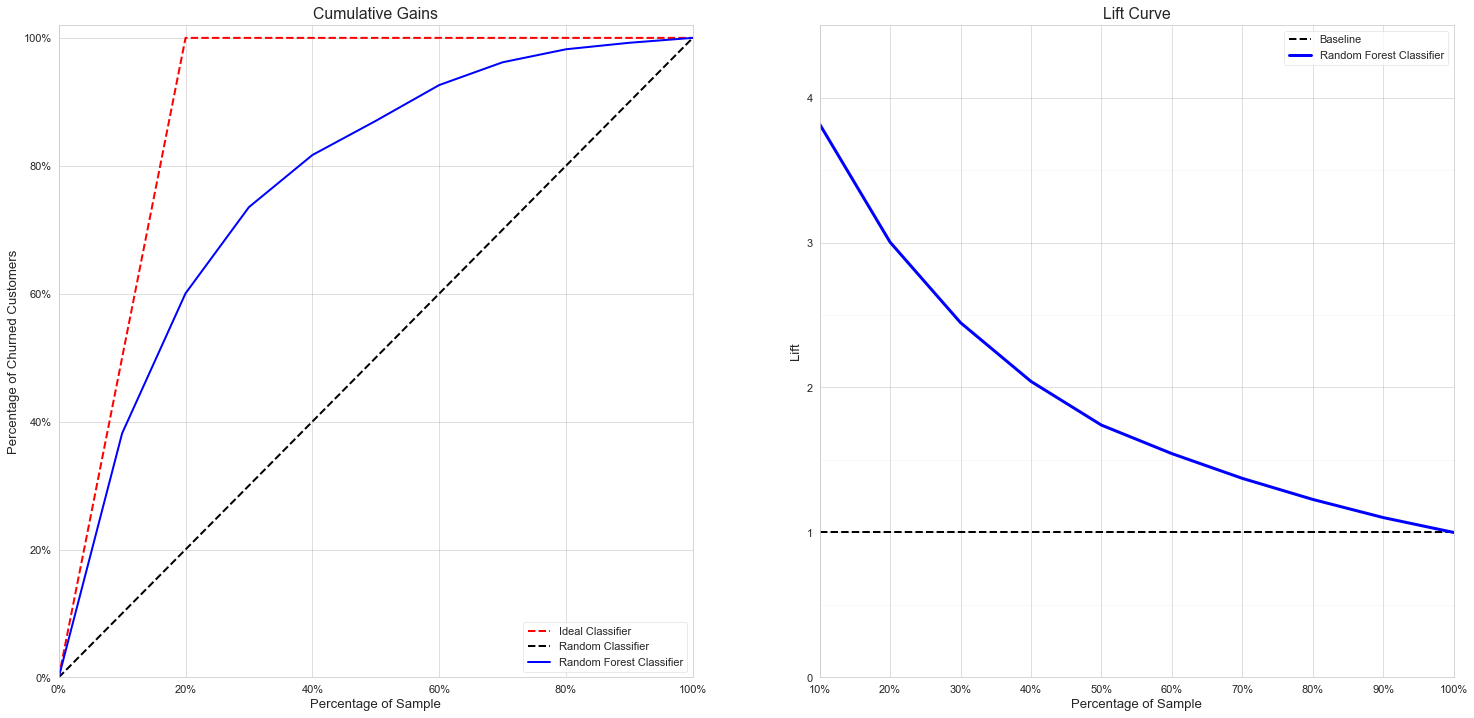

In [134]:
# plot cumulative gain curve and lift curve
lifts, gains = get_lift_gain(rf_model, x_test, y_test)  
plot_lift_gain_curves([gains], [lifts], ['Random Forest Classifier'], churn_ratio=0.2, step=0.1)

## 8.3. Compare Model's Performance

In [135]:
modelling_result = pd.concat( [lr_result, rf_result] )
modelling_result.sort_values( 'F1 Score', ascending=False )

,Model Name,Accuracy,Recall,F1 Score
0,Random Forest Classifier,0.8235,0.646310,0.590012
0,Logistic Regression,0.7420,0.636132,0.492126
